ID #1: 204079453

ID #2: 205714447

In [241]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import random
import warnings

In [242]:
warnings.filterwarnings('ignore')

In [243]:
# stiprows - It can be seen from the dataset that the actual genes matrix starts in line 59. 
df = pd.read_csv('AMI_GSE66360_series_matrix.csv',skiprows=59,header=None)

In [244]:
df = df.T
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

In [245]:
print(df.shape)
df.head()

(99, 54677)


,Class,ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
1,H,GSM1620819,5.866377893,8.22579012,6.17973231,6.179477974,2.792047952,9.290410779,6.998285145,5.348943925,...,13.2573,13.2662,14.5712,14.2766,4.50466,3.13933,2.74701,2.65155,3.41343,3.14061
2,H,GSM1620820,4.948736331,7.525865369,6.628137025,6.58288903,2.69571445,9.462275035,6.558214949,5.410884095,...,13.5939,13.517,14.7388,14.3412,4.40923,3.03996,2.63861,2.64362,3.39906,3.13269
3,H,GSM1620821,5.148384393,7.764636529,5.859151477,6.602134766,2.580181122,9.116776316,6.851622539,5.254073031,...,13.3728,13.4166,14.6272,14.3186,4.31008,3.22011,2.49526,2.62603,3.53997,3.6984
4,H,GSM1620822,5.064418945,7.198461482,5.974135101,6.545904723,2.712123845,9.134584186,7.357827486,5.242139865,...,13.4902,13.4948,14.7541,14.3633,4.43931,3.26378,2.5442,2.50496,3.39623,3.63861
5,H,GSM1620823,5.017832878,7.831450258,6.793079158,5.911542321,2.723686912,9.582343511,7.283872601,5.219483996,...,13.2368,13.3302,14.5484,14.2637,4.56288,3.13852,2.50663,2.60971,3.43472,3.57765


In [248]:
df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x.astype("float"))

In [249]:
df.dtypes

0
Class               object
ID_REF              object
1007_s_at          float64
1053_at            float64
117_at             float64
                    ...   
AFFX-ThrX-5_at     float64
AFFX-ThrX-M_at     float64
AFFX-TrpnX-3_at    float64
AFFX-TrpnX-5_at    float64
AFFX-TrpnX-M_at    float64
Length: 54677, dtype: object

## Analysis:

### Part A: High level description of the data and some pre-processing

Q.1 How many genes profiled? 

In [250]:
print(f"{df.shape[1]-2} genes were profiled in this dataset")

54675 genes were profiled in this dataset


Q.2 How many samples (subjects/patients) in total?

In [251]:
print(f"{df.shape[0]} samples in total")

99 samples in total


Q.3 How many samples in each class?


In [252]:
print("Distrobution of the samples per class:")
df['Class'].value_counts()

Distrobution of the samples per class:


H    50
M    49
Name: Class, dtype: int64

Q.4 If there are missing values, then remove the entire row (gene) from the data matrix. How many rows left now?

In [253]:
df.isna().sum().sort_values(ascending=False)

0
221247_s_at     1
204101_at       1
1565765_x_at    1
1552508_at      1
218117_at       1
               ..
227194_at       0
227193_at       0
227192_at       0
227191_at       0
Class           0
Length: 54677, dtype: int64

In [254]:
df.dropna(axis=1, inplace=True)

In [255]:
print(f"{df.shape[1]} genes left")

54630 genes left


Q.5 Pick 20 genes at random. Draw 20 pair boxplots in one figure comparing expression levels of each of these genes in the two classes M and H.

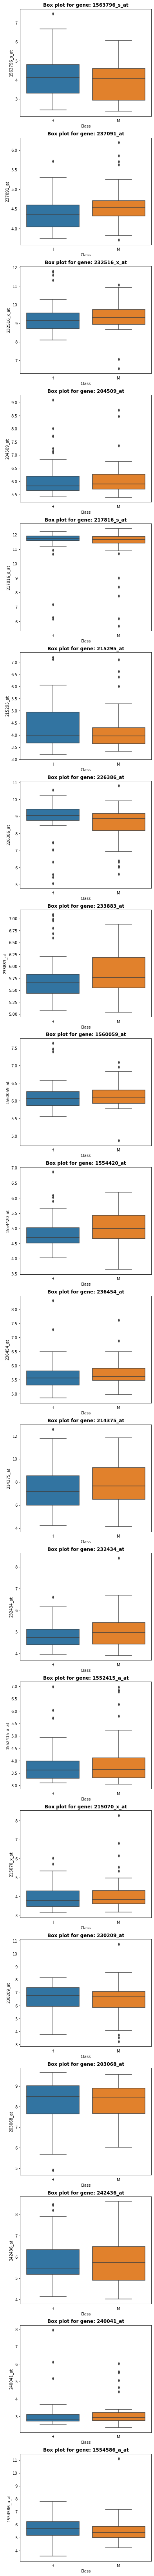

In [256]:
random.seed(1)
random_genes = random.choices(df.columns[2:],k=20)

fig, ax = plt.subplots(nrows=20, figsize=(6,120))

for i, col in enumerate(random_genes):
    axes = sns.boxplot(x='Class', y=df[col], data=df, ax=ax[i])
    axes.set_title(f"Box plot for gene: {col}", fontweight='bold',size=12)


### Part B: WRS for differential expression (DE)

Q1. Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?

B $\rightarrow$ The labeled group M
<br>$E(T) = \frac{B(N+1)}{2} = \frac{49 \cdot (99+1)}{2} = 2450$

Q2. Denote this sum of ranks by RS(g). What is the maximal value, c, that RS(g) can take?

In [257]:
sum_highest_ranks = sum(np.arange(51,100))
print(f"Maximal value, c, that RS(g) can take: {sum_highest_ranks}")

Maximal value, c, that RS(g) can take: 3675


Q3.  Under the null model, what is the probability of RS(g) = c? (Provide a formula for this and explain it)

The null model assumes that there is no difference between Healthy and Myocardial Infraction patients.
<br>Based on the the previous question, the rating for the disese patients has the highest values compared to the healthy ones who receive the low values.
<br>The sample space is N choose B where N=total patients, B=disease patients.
<br>c event can happend in only one configuration over the sample space.
<br>The probability formula for this configuration is: $\frac{1}{N \choose B}$
<br>Therfore, the probability of RS(g) = c under the null model is: $\frac{1}{99 \choose 49}$

Q4. Under the null model, what is the probability of RS(g) = c-1? what is the probability of RS(g) = c-2? (Provide formulas and explain them)

<u>Probability of RS(g) = c-1:</u>
<br>There is only one configuration to achive this result, by switching between ranks 50(healthy) and 51(diseased), so that the 51th will be healthy, and the 50th will be diseased.
<br>Therfore, there is only one configuration to do that replacement the probability will be:
$\frac{1}{99 \choose 49}$
<br><u>Probability of RS(g) = c-2:</u>
<br>There is two configurations to achive this result:
<ul>
    <li>switching between ranks 50(healthy) and 52(diseased), so that the 52th will be healthy, and the 50th will be diseased
        </li>
    <li>switching between ranks 49(healthy) and 51(diseased), so that the 51th will be healthy, and the 49th will be diseased.
        </li>
    </ul> 
<br>Therfore, there are two configurations to do that replacement so the probability will be:
$\frac{2}{99 \choose 49}$

Q5. Draw a histogram of the values of RS(g) in the dataset. Here g ranges over all genes in the data (after the clean-up). Compute the IQR for this distribution and present it on the plot with the histogram

In [258]:
df_ranked = pd.concat([df[df.columns[:2]],df[df.columns[2:]].rank()],axis=1)

In [259]:
q1 = np.quantile(df_ranked[df_ranked['Class']=='M'].iloc[:,2:].sum(), 0.25)
q3 = np.quantile(df_ranked[df_ranked['Class']=='M'].iloc[:,2:].sum(), 0.75)

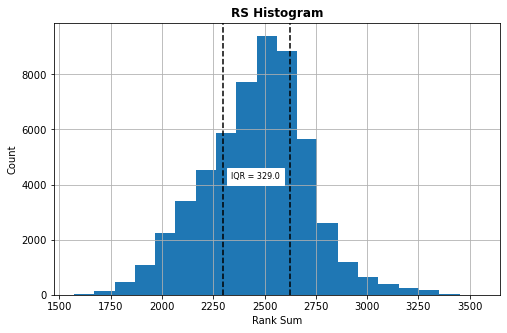

In [835]:
fig, axes = plt.subplots(figsize=(8,5))
df_ranked[df_ranked['Class']=='M'].iloc[:,2:].sum().hist(bins=20)

ax = plt.gca()
ax.axvline(q1, c='black',linestyle='--')
ax.axvline(q3, c='black',linestyle='--')
plt.text(2455,4300, 'IQR = '+str(round(q3-q1,0)), fontsize=8, va='center', ha='center',backgroundcolor='w')
plt.title("RS Histogram", fontweight='bold')
plt.xlabel("Rank Sum")
plt.ylabel("Count")
plt.show()

### Part C: Differential Expression

The purpose is to determine the statistical significance of differential expression (DE) observed for each gene in H vs M.
<br>Evaluate the DE in both one-sided directions for every gene, using both Student t-test and WRS test.
<br>Report the number of genes overexpressed in M vs H (M > H) at a p-value better (≤) than 0.07 and separately genes underexpressed in M vs H (M < H) at a p-value better than 0.07.
<br>For both directions use both a Student t-test and a WRS test.

<b><u>WRS test:

In [721]:
mask_healthy = df['Class']=='H'
mask_disease = df['Class']=='M'

In [722]:
# Since we don't know if there are ties in the data we will use mannwhitneyu 
def calculate_ranksum_under(df):
    return scipy.stats.mannwhitneyu(df[mask_disease],df[mask_healthy],alternative='less')

def calculate_ranksum_over(df):
    return scipy.stats.mannwhitneyu(df[mask_disease],df[mask_healthy], alternative='greater')

In [723]:
# Since the first two columns are not genes we will start from column 2 (0-class, 1-ID_REF)
# underexpressed
df_ranksum_under = df.iloc[:,2:].apply(calculate_ranksum_under)
df_ranksum_under.index=['statistic', 'p_value']
df_ranksum_under = df_ranksum_under.T.reset_index().rename(columns={0:'gene'})

In [724]:
# Since the first two columns are not genes we will start from column 2 (0-class, 1-ID_REF)
# overexpressed
df_ranksum_over = df.iloc[:,2:].apply(calculate_ranksum_over)
df_ranksum_over.index=['statistic', 'p_value']
df_ranksum_over = df_ranksum_over.T.reset_index().rename(columns={0:'gene'})

In [725]:
number_over = df_ranksum_over[df_ranksum_over['p_value']<=0.07]['gene'].count()
number_under = df_ranksum_under[df_ranksum_under['p_value']<=0.07]['gene'].count()

In [726]:
print(f"The number of genes overexpress in M vs H: {number_over}\nThe number of genes underexpressed in M vs H: {number_under}")


The number of genes overexpress in M vs H: 10721
The number of genes underexpressed in M vs H: 10618


<b><u>Student T-test:

In [727]:
def calculate_ttest(df):
    return scipy.stats.ttest_ind(df[mask_disease], df[mask_healthy])

# Since the first two columns are not genes we will start from column 2 (0-class, 1-ID_REF)
ttest_df = df.iloc[:,2:].apply(calculate_ttest)
ttest_df.index=['statistic', 'p_value']
ttest_df = ttest_df.T.reset_index().rename(columns={0:'gene'})

In [728]:
ttest_df_values = ttest_df['statistic'] 
# Since the function returns pvalue for a two sides hypothosis, we will divide it by 2:
ttest_df_p_values = ttest_df['p_value'] / 2  

ttest_number_over = ttest_df[(ttest_df_values > 0) & (ttest_df_p_values < 0.07)]['gene'].count()
ttest_number_under = ttest_df[(ttest_df_values <= 0) & (ttest_df_p_values < 0.07)]['gene'].count()

In [729]:
print(f"For the t-test the number of genes overexpress in M vs H: {ttest_number_over}\nFor the t-test the number of genes underexpressed in M vs H: {ttest_number_under}")


For the t-test the number of genes overexpress in M vs H: 8517
For the t-test the number of genes underexpressed in M vs H: 8639


### Part D: Correlations

Select the 80 most significant genes from each one of the onesided WRS DE lists you computed in 3c. Generate a set of 160 genes, D, which is the union of the above two sets

Q1. Compute Kendall 𝜏 correlations in all pairs within D (160 choose 2 numbers). Represent the correlation matrix as a 160x160 heatmap.

In [730]:
over_samples = df_ranksum_over[df_ranksum_over['p_value']<=0.07].sort_values(by='p_value').head(80)['gene']
under_samples = df_ranksum_under[df_ranksum_under['p_value']<=0.07].sort_values(by='p_value').head(80)['gene']

In [731]:
list_over_under_genes = over_samples.append(under_samples)
list_over_under_genes = list_over_under_genes.tolist()

In [732]:
D = df[list_over_under_genes]

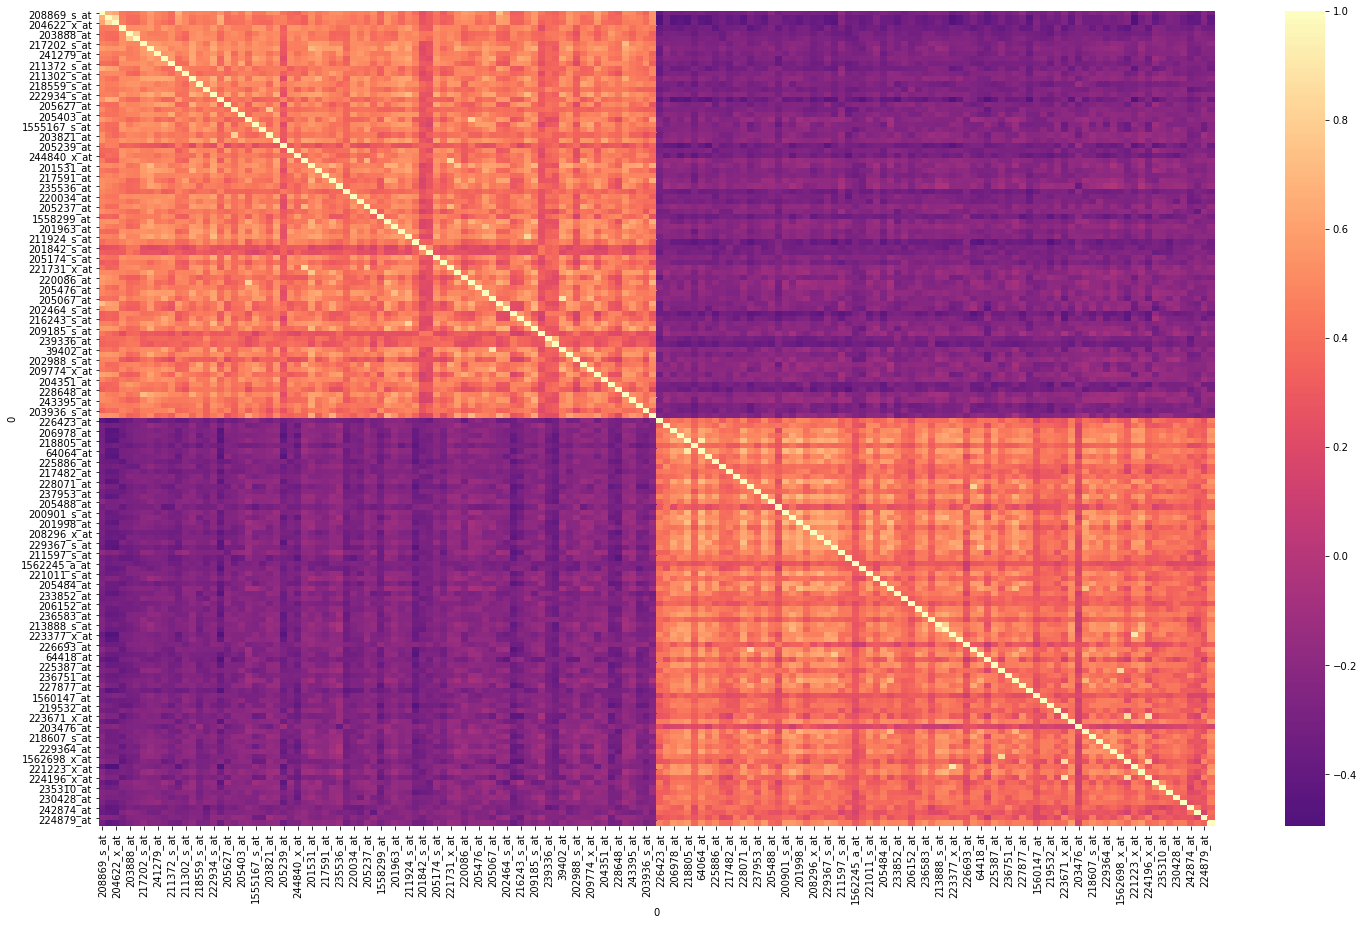

In [733]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(D.corr(method='kendall'), center=0, cmap='magma')
plt.show()

Q2. Under a NULL model that assumes that genes are pairwise independent, what is the expected value for 𝜏? 

<b>Answer:</b> Under a NULL model that assumes that genes are pairwise independent, we would expect the expected value for 𝜏 to be approximately zero

Q3. Now compute the Kendall 𝜏 correlations in all 80 choose 2 pairs from the overexpressed genes in D. 
<br>Present your results on a histogram. What is the average value you observed? 
<br>Compare it to the value in the above section. Explain.

In [734]:
over_samples = over_samples.tolist()
D_over = df[over_samples]

In [735]:
# Compute the correlation matrix
corr_over = D_over.corr(method='kendall')
mask = np.tril_indices(80)
corr_over_np = corr_over.to_numpy()
corr_over_np[mask] = -1

In [736]:
# get all the number above the diagonal:
corr_over_arr = corr_over_np[corr_over_np>-1][~np.isnan(corr_over_np[corr_over_np>-1])]

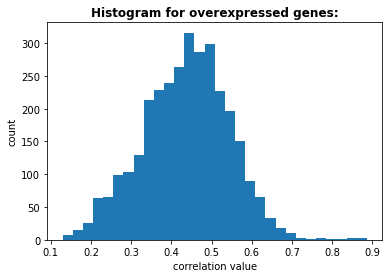

In [841]:
plt.hist(corr_over_arr, bins=30)
plt.title("Histogram for overexpressed genes:", fontweight='bold')
plt.xlabel("correlation value")
plt.ylabel("count")
plt.show()

In [738]:
print(f"The average correlation of the 80 overexpressed genes is: {round(corr_over_arr.mean(),3)}")

The average correlation of the 80 overexpressed genes is: 0.436


In [739]:
# Compute the correlation matrix
corr = D.corr(method='kendall')
mask = np.tril_indices(160)
corr_np = corr.to_numpy()
corr_np[mask] = -1
corr_arr = corr_np[corr_np>-1][~np.isnan(corr_np[corr_np>-1])]

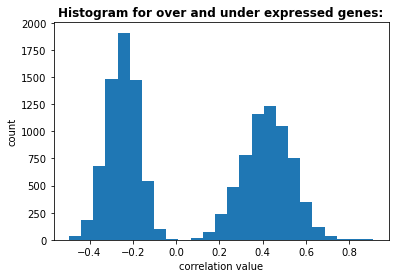

In [842]:
plt.hist(corr_arr,bins=25)
plt.title("Histogram for over and under expressed genes:", fontweight='bold')
plt.xlabel("correlation value")
plt.ylabel("count")
plt.show()

In [845]:
print(f"The average correlation of the 160 over and under expressed genes is: {round(corr_arr.mean(),3)}")

The average correlation of the 160 over and under expressed genes is: 0.084


<b>Explantion:</b>
<br>At Q2. with 160 samples from both groups, as we expected, the correlation is 0 because we took both edges so there were aprroximatly half concordant and half discordant. 
<br>Compared to Q3. with 80 samples from the overexpressed group, the left tail is not exist, therefore we will see less discordant, as can be seen from the mean of the tau correlation which is a positive value.

Q4. What can you report about co-expression of genes in D (coexpression is inferred from the correlation of the expression levels of genes, across a set of samples)?

In [742]:
def calc_kendall_p_value(x,y):
        return scipy.stats.kendalltau(x,y)[1]

In [743]:
#The two general steps for constructing a gene co-expression network: 
#calculating co-expression score (e.g. the absolute value of the correlation coefficient) 
#for each pair of genes, and selecting a significance threshold (e.g. correlation >= 0.5).
D_corr = D.corr(method='kendall')
D_corr_p_value = D.corr(method=calc_kendall_p_value)
strog_D_corr = ((D_corr_p_value < 0.05) & (abs(D_corr) >= 0.5)).sum().sum()/2-160


In [744]:
print(f"The number of significant co-expression genes is: {int(strog_D_corr)}")

The number of significant co-expression genes is: 1361


Q5. What can you say about how many co-expressed pairs we would observe (in the entire dataset) at FDR=0.05? <br>Explain your answer

In [745]:
# Compute the correlation matrix
mask = np.tril_indices(160)
q5_corr_np = D_corr_p_value.to_numpy()
q5_corr_np[mask] = -1
q5_corr_np = q5_corr_np[q5_corr_np>-1][~np.isnan(q5_corr_np[q5_corr_np>-1])]

In [746]:
p_values_arr = np.sort(q5_corr_np)

In [747]:
fdr = np.divide(p_values_arr*len(p_values_arr), np.arange(1,len(p_values_arr)+1))

In [748]:
index = np.searchsorted(fdr, 0.05)

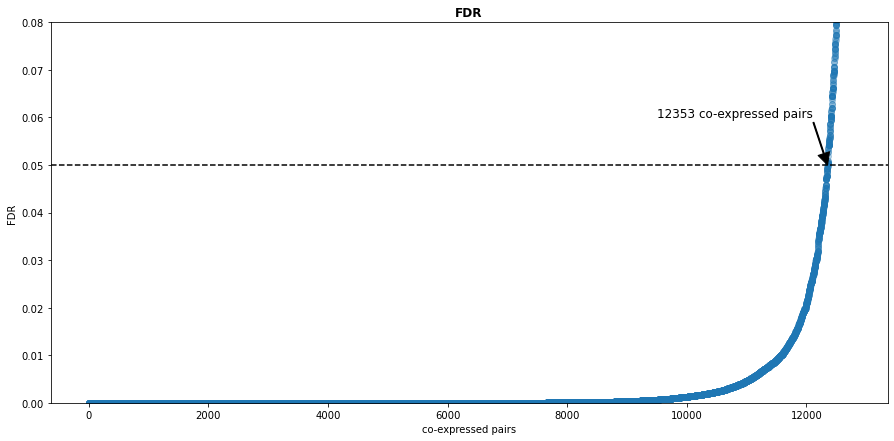

In [846]:
fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(np.arange(1,len(p_values_arr)+1),fdr,alpha=0.3)
plt.ylim((0, 0.08))
ax.axhline(0.05, c='black',linestyle='--')
ax.annotate(str(index)+' co-expressed pairs', xy=(index,0.05), xytext=(9500,0.06),size=12, arrowprops=dict(width=1, fc='black'))
plt.title("FDR", fontweight='bold')
plt.xlabel("co-expressed pairs")
plt.ylabel("FDR")

plt.show()

In [750]:
print(f"The amount of co-expressed pairs under FDR 0.05 is: {index}")

The amount of co-expressed pairs under FDR 0.05 is: 12353


In [751]:
print(f"We can infer that according to the fdr thershold we can report {index} genes which is {round((index/len(q5_corr_np))*100,2)}% from the total\nco-expressed genes.")


We can infer that according to the fdr thershold we can report 12353 genes which is 97.11% from the total
co-expressed genes.


Q6. What would have been advantages and disadvantages of computing co-expression for all genes in the study rather than only for genes in D?

<b><u>Advantages:</u></b>
<br>We might find more correlations in the data due to the additional information in this method. 
<br><b><u>Disadvantages:</u></b>
<br>Adding more genes will square the number of p-values that might result a noisey data, therfore the FDR will increase, so it is not certain that we will achieve the result we are trying to achieve. In conculsion, adding more datapoints can cause to adverse effects.

        
         

### Part E: Plots and Conclusions of the DE and correlation analysis

Q1. Construct the DE overabundance plots (blue and green lines as shown in class) for M vs H overexpression (higher expression levels in M) using WRS and t-test using the results you had computed in Section 3c.
<br>State, for each comparison, the number of genes, k, at which
we observe:
<br>a) FDR = 0.05
<br>b) FDR = 0.01
<br>c) FDR = 0.005
<br>If these events are not observed at any k>0, then make that
statement.

In [752]:
def create_overabundance_plot(p_values, title):
    plt.figure(figsize = (8, 5))
    p_arr = np.sort(p_values)
    N = len(p_arr)
    p_null = np.linspace(0, 1.0, N)
    y = np.arange(N)
    plt.title(title, fontsize=20)
    plt.xlabel("p-value(i)", fontsize=15)
    plt.ylabel("i", fontsize=15)
    plt.plot(p_arr, y, color='g', label='Actual distribution')
    plt.plot(p_null, y, color='b', label='Null distribution')
    plt.legend()

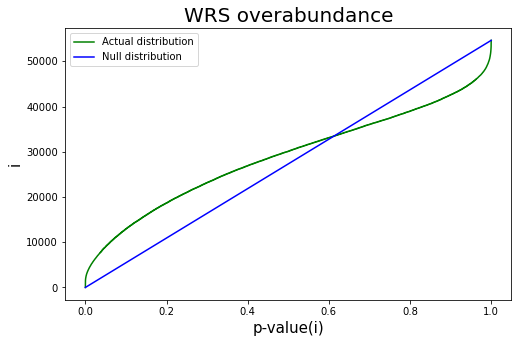

In [753]:
create_overabundance_plot(df_ranksum_over['p_value'], title='WRS overabundance')

In [754]:
ttest_df_temp = ttest_df.copy()

ttest_df['p_value'] = ttest_df['p_value'] / 2
left_side_mask = ttest_df_temp['statistic'] < 0
ttest_df_temp['p_value'][left_side_mask] = 1 - ttest_df_temp['p_value'][left_side_mask]

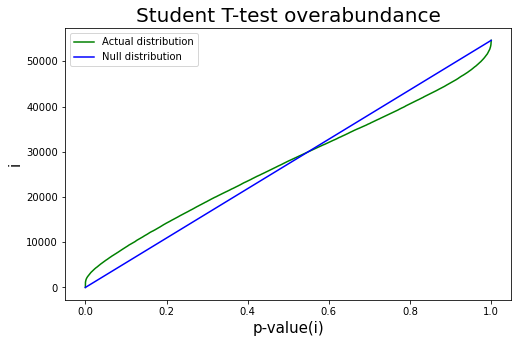

In [755]:
create_overabundance_plot(ttest_df_copy['p_value'], title='Student T-test overabundance')

In [756]:
def calculate_fdr (p_value_arr, threshold):
    N = len(p_value_arr)
    i = np.arange(1,len(p_value_arr)+1)
    fdr = np.divide(p_value_arr*N, i)
    index = np.searchsorted(fdr, threshold)
    return index 

In [855]:
print("Student T-test:")
print(f"We can report {calculate_fdr(ttest_df_temp['p_value'].sort_values(), 0.05)} genes at FDR 0.05") 
print(f"We can report {calculate_fdr(ttest_df_temp['p_value'].sort_values(), 0.01)} genes at FDR 0.01") 
print(f"We can report {calculate_fdr(ttest_df_temp['p_value'].sort_values(), 0.005)} genes at FDR 0.005") 
print("----------")
print("WRS:")
print(f"We can report {calculate_fdr(df_ranksum_over['p_value'].sort_values(), 0.05)} genes at FDR 0.05") 
print(f"We can report {calculate_fdr(df_ranksum_over['p_value'].sort_values(), 0.01)} genes at FDR 0.01") 
print(f"We can report {calculate_fdr(df_ranksum_over['p_value'].sort_values(), 0.005)} genes at FDR 0.005") 

Student T-test:
We can report 1689 genes at FDR 0.05
We can report 1112 genes at FDR 0.01
We can report 961 genes at FDR 0.005
----------
WRS:
We can report 2784 genes at FDR 0.05
We can report 1601 genes at FDR 0.01
We can report 1322 genes at FDR 0.005


Q2. Select any 3 differentially expressed genes, from D (which was defined in 3d), and produce a graphical representation of their expression patterns that demonstrates the observed DE.

In [856]:
D_samples = df_ranksum_over.sample(n=3)
D_samples = D_samples.set_index('gene')
D_samples = df[D_samples.index]

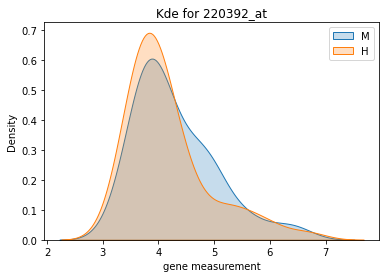

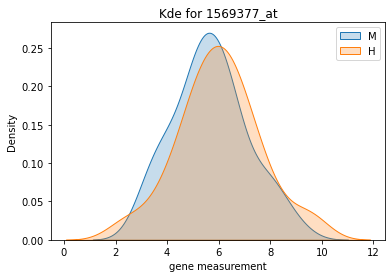

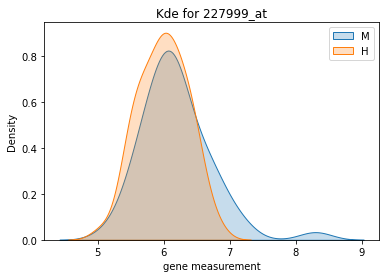

In [859]:
for col in D_samples.columns:
    sns.kdeplot(D_samples[mask_disease][col], shade=True, label='M')
    sns.kdeplot(D_samples[mask_healthy][col], shade=True, label='H')
    plt.title(f"Kde for {col}")
    plt.xlabel('gene measurement')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Q3. Heatmap
<br>Draw a heatmap representation of the expression values of the genes in D (from 3d), across the entire cohort (all samples). Order the genes and the samples to produce the maximal visual effect.

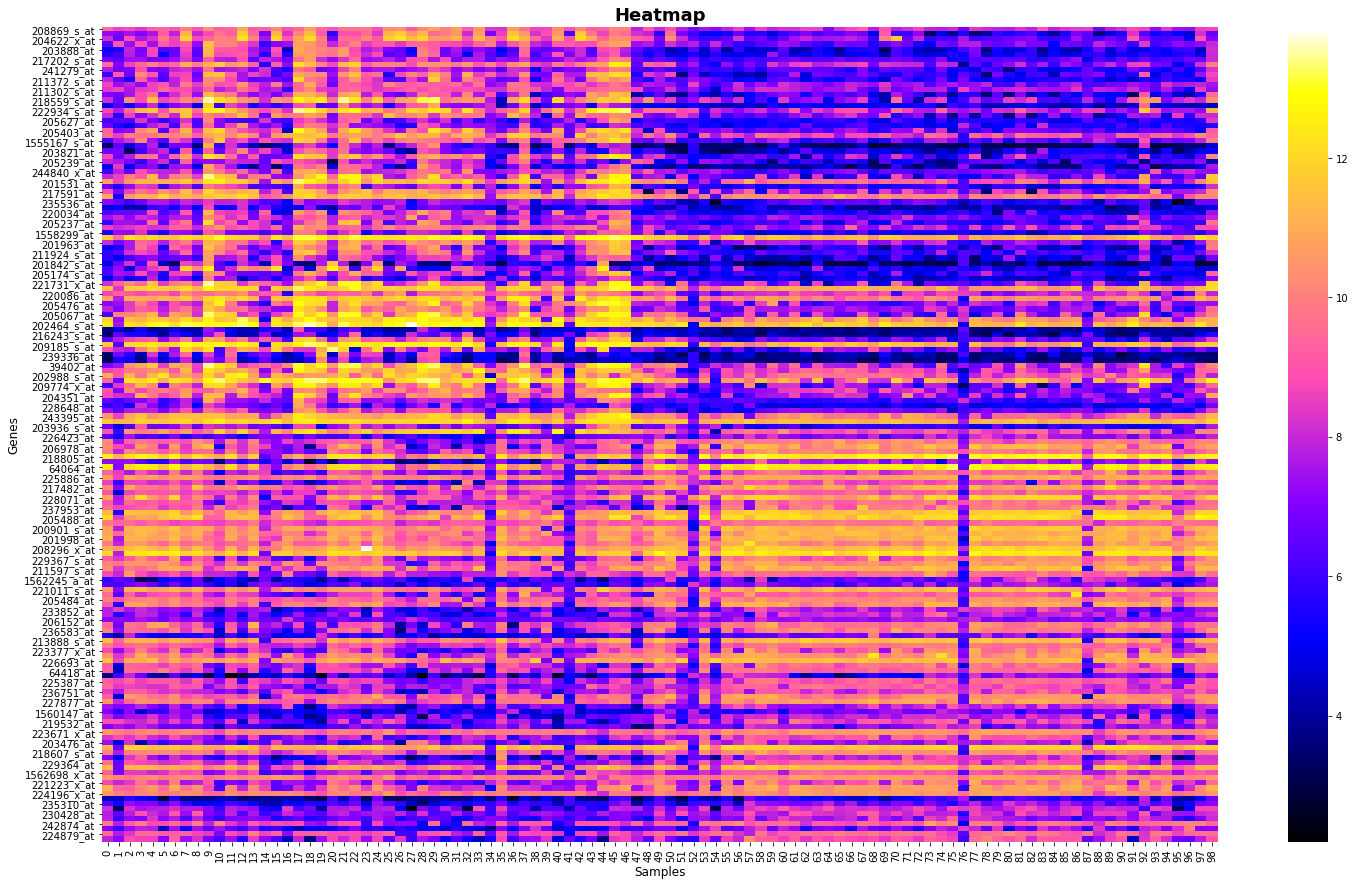

In [878]:
over_df = df[over_samples]
under_df = df[under_samples]

# In order to produce the maximal visual effect:
healthy_over = over_df.T[df[mask_healthy].index]
healthy_under = under_df.T[df[mask_healthy].index]
disease_over = over_df.T[df[mask_disease].index]
disease_under = under_df.T[df[mask_disease].index]

under_genes = pd.concat([disease_under, healthy_under], axis=1, ignore_index=True)
over_genes = pd.concat([disease_over, healthy_over], axis=1, ignore_index=True)
all_genes = pd.concat([over_genes, under_genes])

cmap = sns.cubehelix_palette(as_cmap=True)

plt.figure(figsize = (25, 15))
sns.heatmap(all_genes, cmap='gnuplot2')
plt.title('Heatmap', fontsize=18, fontweight='bold')
plt.xlabel('Samples', fontsize=12)
plt.ylabel('Genes', fontsize=12)
plt.show()